In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mariamkokozashvili","key":"9c56b329b879cdf05e842b61438f1324"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Merging basic data...
After merge - Train shape: (421570, 5)
After merge - Test shape: (115064, 4)
Single Store-Department Validation
Training SARIMA for Store 1, Dept 1
Data points: 143
Results for Store 1, Dept 1:
  MAE: 1502.12
  RMSE: 2566.95
  WMAE: 1058.54

Plotting results for Store 1, Dept 1...


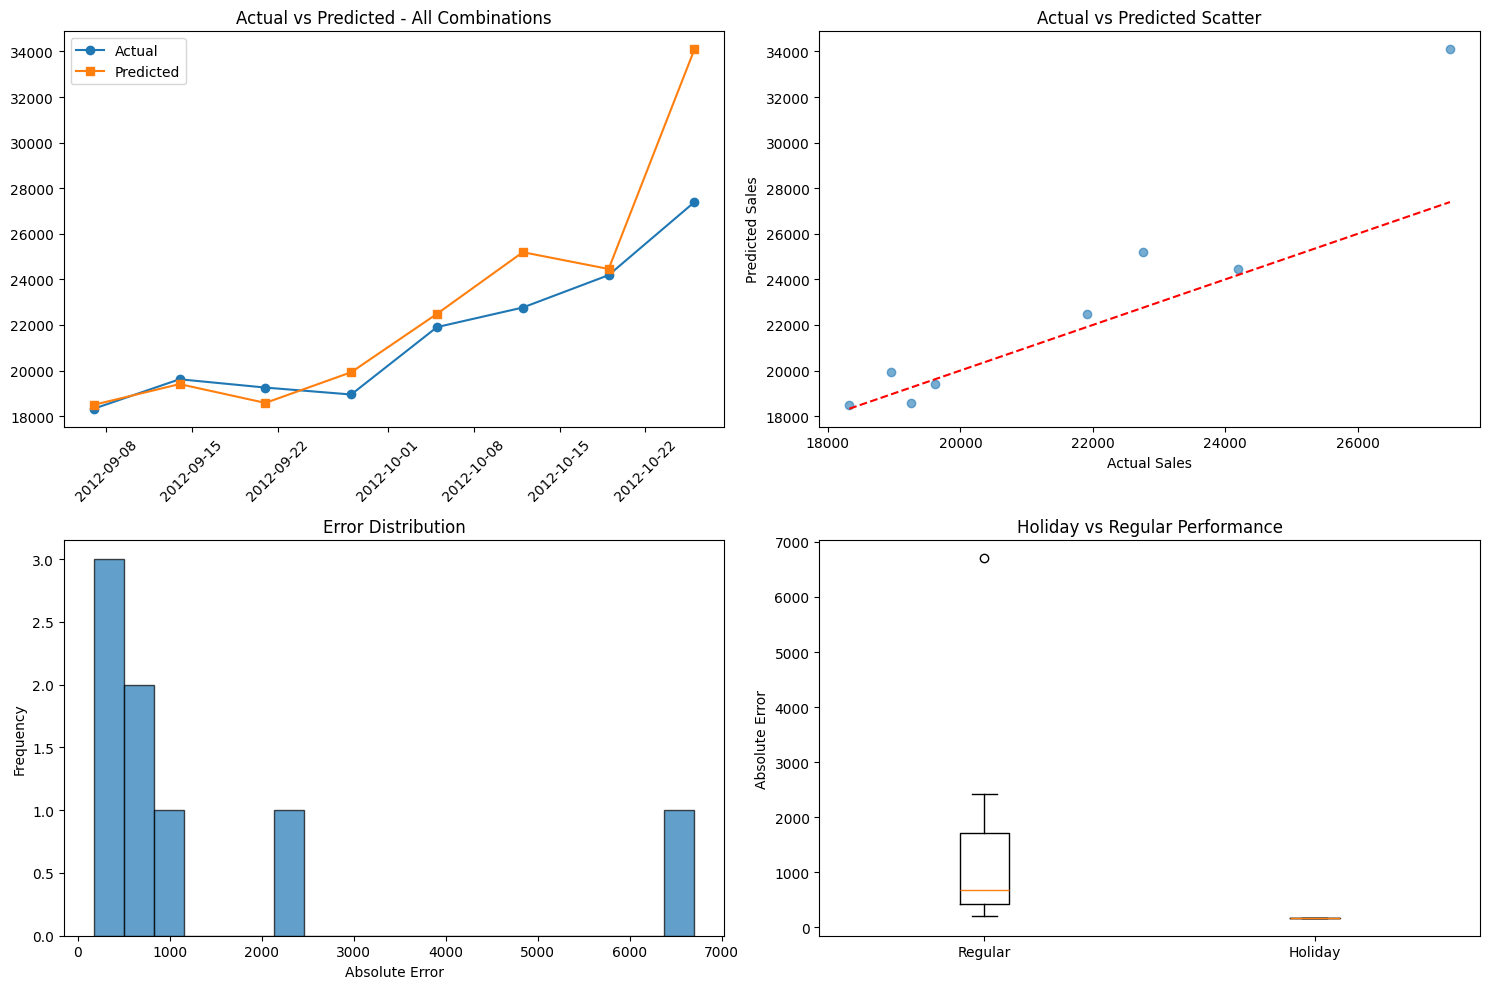

Multiple Store-Department Validation
Validating on 10 store-department combinations
Training SARIMA for Store 14, Dept 92
Data points: 143
Results for Store 14, Dept 92:
  MAE: 11871.57
  RMSE: 14139.87
  WMAE: 16084.26
Training SARIMA for Store 2, Dept 92
Data points: 143
Results for Store 2, Dept 92:
  MAE: 4586.96
  RMSE: 6210.74
  WMAE: 4378.97
Training SARIMA for Store 20, Dept 92
Data points: 143
Results for Store 20, Dept 92:
  MAE: 7691.43
  RMSE: 8948.41
  WMAE: 10424.61
Training SARIMA for Store 13, Dept 92
Data points: 143
Results for Store 13, Dept 92:
  MAE: 9608.02
  RMSE: 12051.63
  WMAE: 9193.71
Training SARIMA for Store 4, Dept 92
Data points: 143
Results for Store 4, Dept 92:
  MAE: 3476.48
  RMSE: 4023.05
  WMAE: 2385.25
Training SARIMA for Store 20, Dept 95
Data points: 143
Results for Store 20, Dept 95:
  MAE: 3556.36
  RMSE: 3980.03
  WMAE: 2420.95
Training SARIMA for Store 4, Dept 95
Data points: 143
Results for Store 4, Dept 95:
  MAE: 5664.84
  RMSE: 5909.13
  

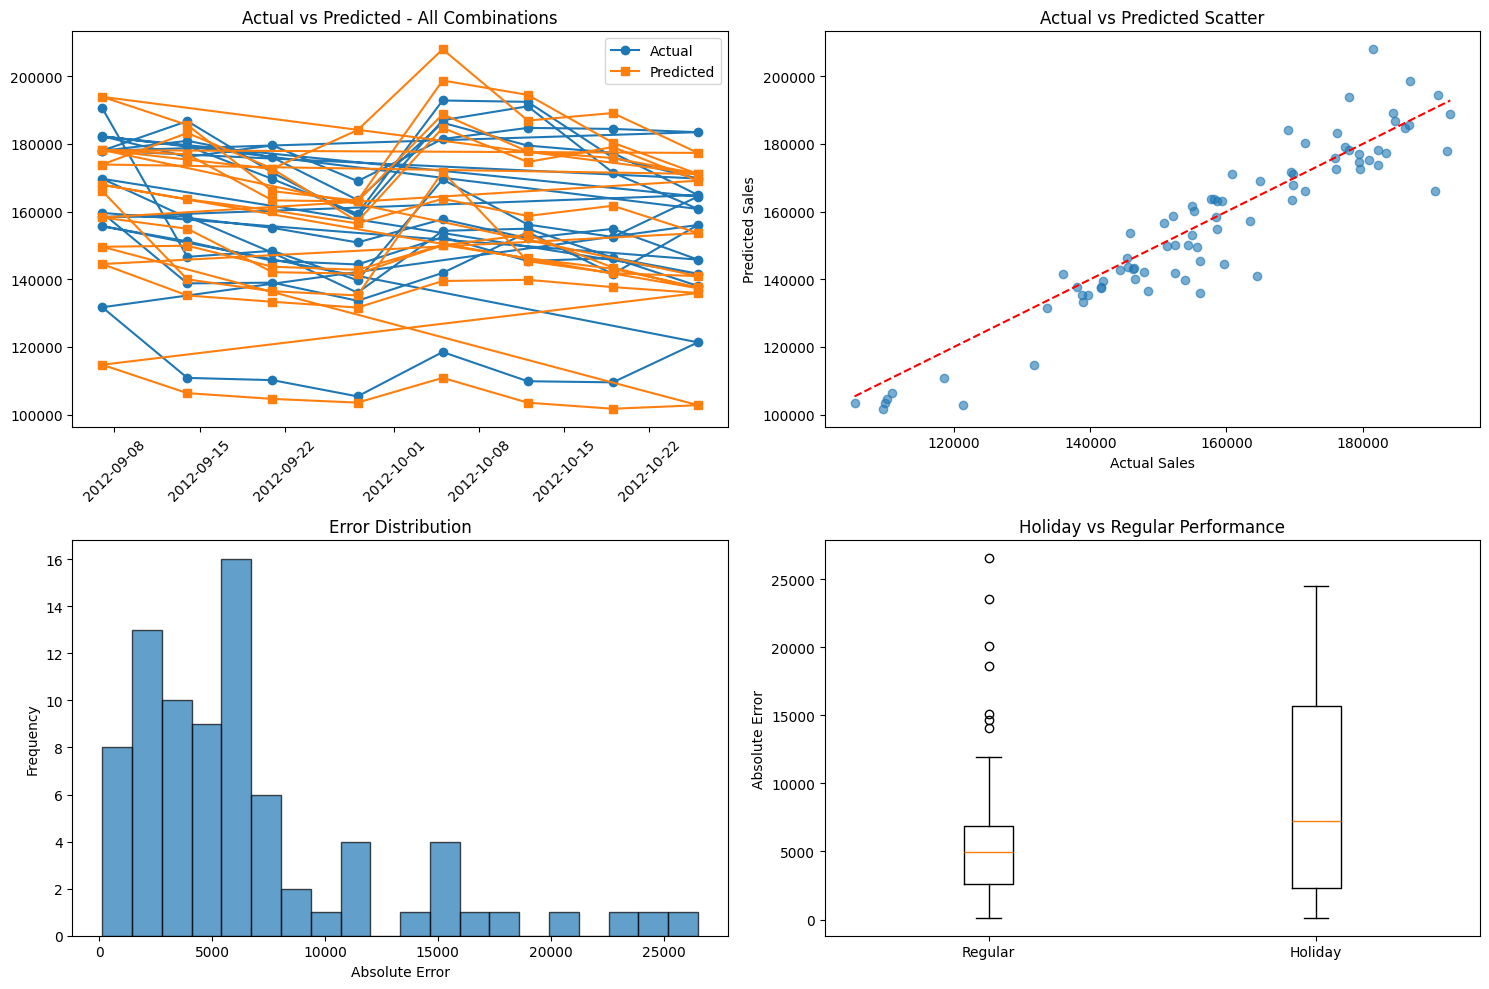


Detailed Metrics by Store-Department:
            mae          rmse          wmae  Store  Dept
0  11871.567079  14139.868210  16084.262079     14    92
1   4586.957698   6210.739914   4378.973478      2    92
2   7691.432127   8948.407888  10424.611596     20    92
3   9608.016162  12051.626083   9193.705289     13    92
4   3476.476602   4023.046346   2385.254575      4    92
5   3556.363948   3980.034640   2420.951741     20    95
6   5664.839439   5909.130021   4365.723413      4    95
7   8351.581739  10611.799247  10608.359146     27    92
8   8659.113779  10297.631188  11437.195994     14    95
9   2187.959050   2759.098481   3489.661399      2    95


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class SimpleSARIMA:
    def __init__(self):
        self.train_df = None
        self.test_df = None
        self.features_df = None
        self.stores_df = None

    def load_data(self, train_path, test_path, features_path, stores_path):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.features_df = pd.read_csv(features_path)
        self.stores_df = pd.read_csv(stores_path)

        self.train_df['Date'] = pd.to_datetime(self.train_df['Date'])
        self.test_df['Date'] = pd.to_datetime(self.test_df['Date'])
        self.features_df['Date'] = pd.to_datetime(self.features_df['Date'])

        print(f"Train shape: {self.train_df.shape}")
        print(f"Test shape: {self.test_df.shape}")

        return self.train_df, self.test_df

    def merge_basic_data(self):
        self.train_df = self.train_df.merge(
            self.features_df[['Store', 'Date', 'IsHoliday']],
            on=['Store', 'Date'],
            how='left',
            suffixes=('', '_features')
        )

        self.train_df['IsHoliday'] = self.train_df['IsHoliday_features'].fillna(self.train_df['IsHoliday'])
        self.train_df.drop('IsHoliday_features', axis=1, inplace=True)

        self.test_df = self.test_df.merge(
            self.features_df[['Store', 'Date', 'IsHoliday']],
            on=['Store', 'Date'],
            how='left',
            suffixes=('', '_features')
        )

        self.test_df['IsHoliday'] = self.test_df['IsHoliday_features'].fillna(self.test_df['IsHoliday'])
        self.test_df.drop('IsHoliday_features', axis=1, inplace=True)

        print(f"After merge - Train shape: {self.train_df.shape}")
        print(f"After merge - Test shape: {self.test_df.shape}")

        return self.train_df, self.test_df

    def train_sarima_single(self, store=1, dept=1, validation_weeks=8,
                           order=(1,1,1), seasonal_order=(1,1,1,52)):

        store_dept_data = self.train_df[
            (self.train_df['Store'] == store) &
            (self.train_df['Dept'] == dept)
        ].copy()

        store_dept_data = store_dept_data.sort_values('Date')

        if len(store_dept_data) < validation_weeks + 10:
            print(f"Not enough data for Store {store}, Dept {dept}")
            return None, None, None

        print(f"Training SARIMA for Store {store}, Dept {dept}")
        print(f"Data points: {len(store_dept_data)}")
        ts = store_dept_data['Weekly_Sales'].values
        dates = store_dept_data['Date'].values

        train_ts = ts[:-validation_weeks]
        val_ts = ts[-validation_weeks:]
        val_dates = dates[-validation_weeks:]

        try:
            model = SARIMAX(
                train_ts,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            results = model.fit(disp=False, maxiter=50)

            forecast = results.get_forecast(steps=validation_weeks)
            predictions = forecast.predicted_mean

            mae = mean_absolute_error(val_ts, predictions)
            mse = mean_squared_error(val_ts, predictions)
            rmse = np.sqrt(mse)

            val_data = store_dept_data.tail(validation_weeks)
            weights = val_data['IsHoliday'].apply(lambda x: 5 if x == 1 else 1).values
            wmae = np.sum(weights * np.abs(val_ts - predictions)) / np.sum(weights)

            print(f"Results for Store {store}, Dept {dept}:")
            print(f"  MAE: {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  WMAE: {wmae:.2f}")

            results_df = pd.DataFrame({
                'Date': val_dates,
                'Actual': val_ts,
                'Predicted': predictions,
                'Error': np.abs(val_ts - predictions),
                'IsHoliday': val_data['IsHoliday'].values
            })

            return results, results_df, {'mae': mae, 'rmse': rmse, 'wmae': wmae}

        except Exception as e:
            print(f"Error training SARIMA for Store {store}, Dept {dept}: {str(e)}")
            return None, None, None

    def validate_multiple_stores(self, store_dept_pairs=None, validation_weeks=8,
                                order=(1,1,1), seasonal_order=(1,1,1,52)):

        if store_dept_pairs is None:
            top_combinations = (self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales']
                              .sum().nlargest(10).index.tolist())
        else:
            top_combinations = store_dept_pairs

        print(f"Validating on {len(top_combinations)} store-department combinations")

        all_results = []
        all_metrics = []

        for store, dept in top_combinations:
            model, results_df, metrics = self.train_sarima_single(
                store=store,
                dept=dept,
                validation_weeks=validation_weeks,
                order=order,
                seasonal_order=seasonal_order
            )

            if results_df is not None:
                results_df['Store'] = store
                results_df['Dept'] = dept
                all_results.append(results_df)

                metrics['Store'] = store
                metrics['Dept'] = dept
                all_metrics.append(metrics)

        if all_results:
            combined_results = pd.concat(all_results, ignore_index=True)
            combined_metrics = pd.DataFrame(all_metrics)

            overall_mae = combined_results['Error'].mean()
            overall_rmse = np.sqrt(combined_results['Error'].var())

            weights = combined_results['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)
            overall_wmae = np.sum(weights * combined_results['Error']) / np.sum(weights)

            print(f"\nOverall Validation Results:")
            print(f"Overall MAE: {overall_mae:.2f}")
            print(f"Overall RMSE: {overall_rmse:.2f}")
            print(f"Overall WMAE: {overall_wmae:.2f}")

            return combined_results, combined_metrics, {
                'overall_mae': overall_mae,
                'overall_rmse': overall_rmse,
                'overall_wmae': overall_wmae
            }
        else:
            print("No successful validations!")
            return None, None, None

    def plot_results(self, results_df, store=None, dept=None):

        if store is not None and dept is not None:
            plot_data = results_df[
                (results_df['Store'] == store) &
                (results_df['Dept'] == dept)
            ]
            title = f"Store {store}, Dept {dept}"
        else:
            plot_data = results_df
            title = "All Combinations"

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Time series plot
        axes[0, 0].plot(plot_data['Date'], plot_data['Actual'],
                       label='Actual', marker='o')
        axes[0, 0].plot(plot_data['Date'], plot_data['Predicted'],
                       label='Predicted', marker='s')
        axes[0, 0].set_title(f'Actual vs Predicted - {title}')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Scatter plot
        axes[0, 1].scatter(plot_data['Actual'], plot_data['Predicted'], alpha=0.6)
        axes[0, 1].plot([plot_data['Actual'].min(), plot_data['Actual'].max()],
                       [plot_data['Actual'].min(), plot_data['Actual'].max()], 'r--')
        axes[0, 1].set_xlabel('Actual Sales')
        axes[0, 1].set_ylabel('Predicted Sales')
        axes[0, 1].set_title('Actual vs Predicted Scatter')

        # Error distribution
        axes[1, 0].hist(plot_data['Error'], bins=20, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Absolute Error')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Error Distribution')

        # Holiday vs Regular performance
        holiday_errors = plot_data[plot_data['IsHoliday'] == 1]['Error']
        regular_errors = plot_data[plot_data['IsHoliday'] == 0]['Error']

        axes[1, 1].boxplot([regular_errors, holiday_errors],
                          labels=['Regular', 'Holiday'])
        axes[1, 1].set_ylabel('Absolute Error')
        axes[1, 1].set_title('Holiday vs Regular Performance')

        plt.tight_layout()
        plt.show()

def main():
    sarima = SimpleSARIMA()
    train_path = '/content/drive/MyDrive/ML/final/train.csv'
    test_path = '/content/drive/MyDrive/ML/final/test.csv'
    features_path = '/content/drive/MyDrive/ML/final/features.csv'
    stores_path = '/content/drive/MyDrive/ML/final/stores.csv'

    print("Loading data...")
    sarima.load_data(train_path, test_path, features_path, stores_path)

    print("Merging basic data...")
    sarima.merge_basic_data()
    print("Single Store-Department Validation")

    model, results_df, metrics = sarima.train_sarima_single(
        store=1,
        dept=1,
        validation_weeks=8,
        order=(1,1,1),
        seasonal_order=(1,1,1,52)
    )

    if results_df is not None:
        print("\nPlotting results for Store 1, Dept 1...")
        sarima.plot_results(results_df)

    print("Multiple Store-Department Validation")

    combined_results, combined_metrics, overall_metrics = sarima.validate_multiple_stores(
        store_dept_pairs=None,
        validation_weeks=8,
        order=(1,1,1),
        seasonal_order=(1,1,1,52)
    )

    if combined_results is not None:
        print("\nPlotting combined results...")
        sarima.plot_results(combined_results)
        print("\nDetailed Metrics by Store-Department:")
        print(combined_metrics)

    return sarima, combined_results, combined_metrics

if __name__ == "__main__":
    sarima, results, metrics = main()

Loading data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Merging basic data...
After merge - Train shape: (421570, 5)
After merge - Test shape: (115064, 4)
Single Store-Department Validation
Training SARIMA for Store 1, Dept 1
Data points: 143
Results for Store 1, Dept 1:
  MAE: 1502.12
  RMSE: 2566.95
  WMAE: 1058.54

Plotting results for Store 1, Dept 1...


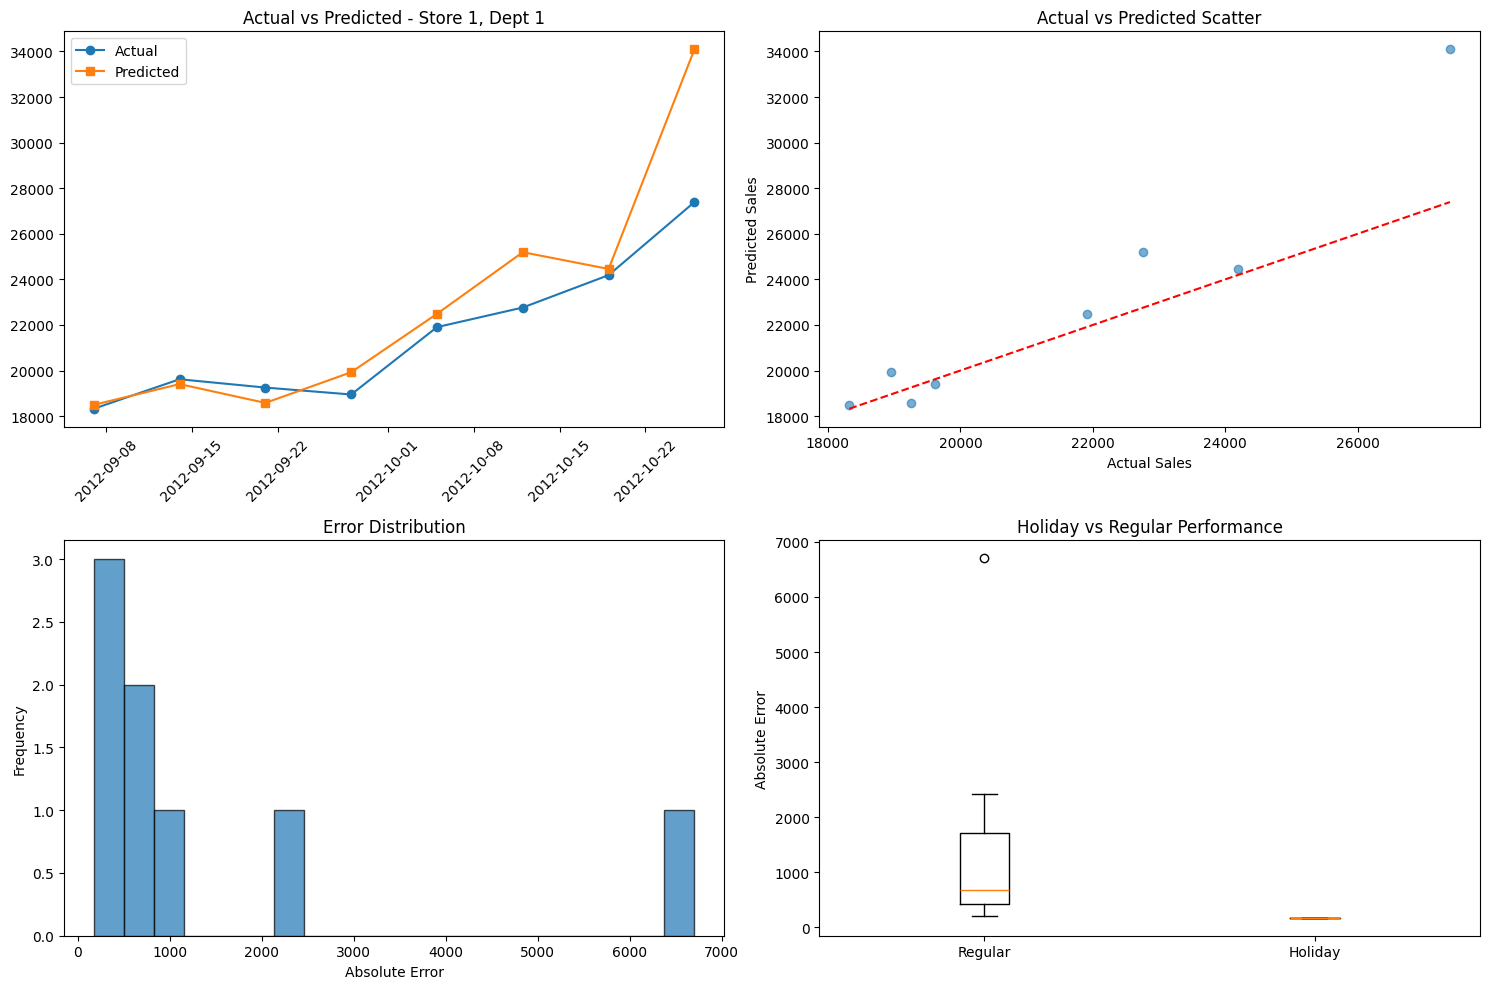

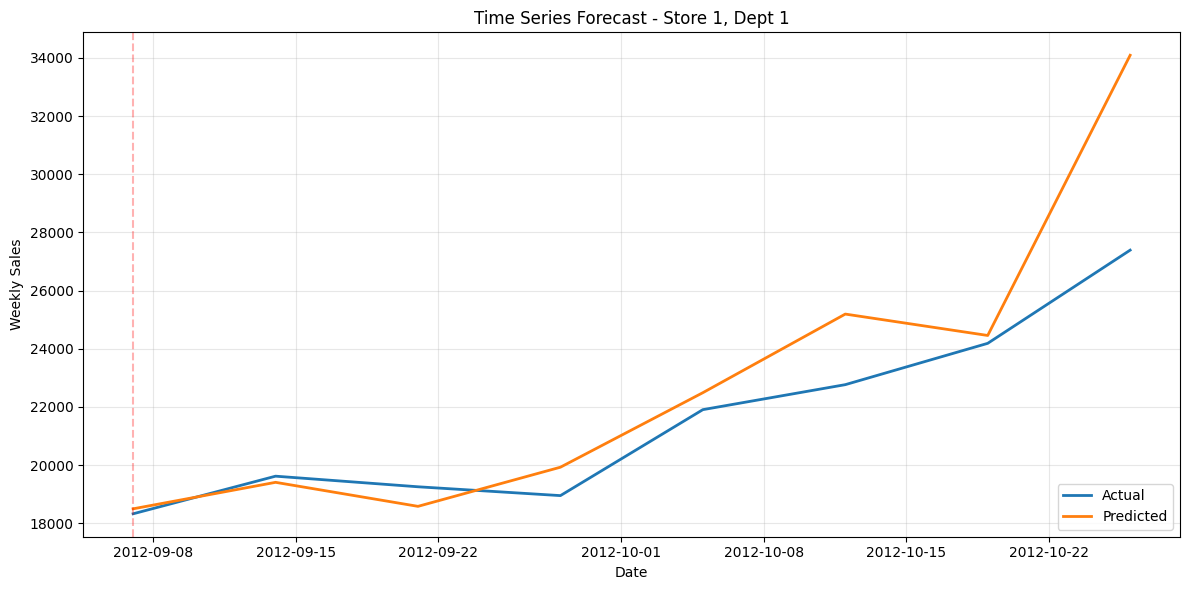

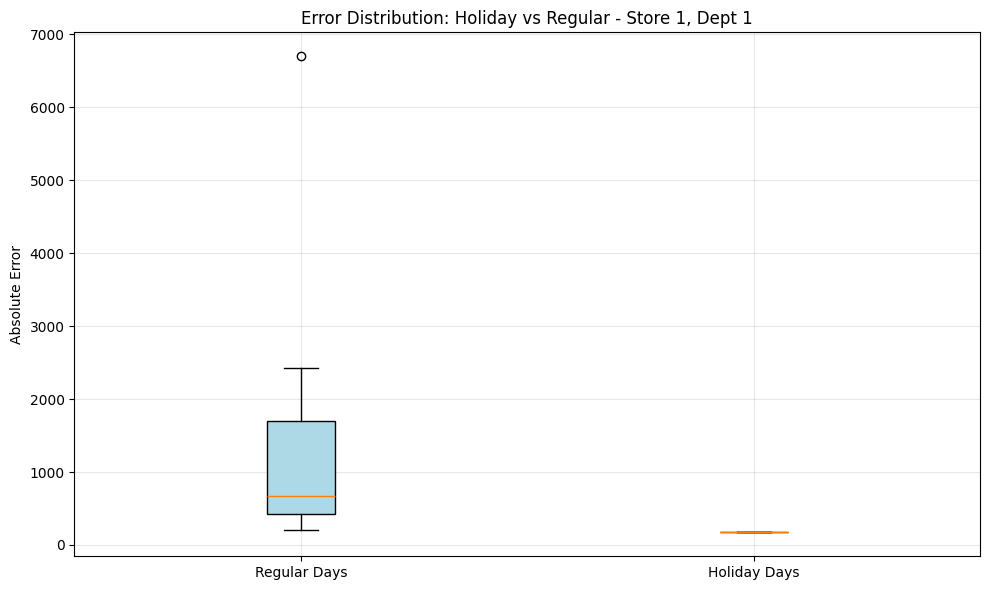

Multiple Store-Department Validation
Validating on 10 store-department combinations
Training SARIMA for Store 14, Dept 92
Data points: 143
Results for Store 14, Dept 92:
  MAE: 11871.57
  RMSE: 14139.87
  WMAE: 16084.26
Training SARIMA for Store 2, Dept 92
Data points: 143
Results for Store 2, Dept 92:
  MAE: 4586.96
  RMSE: 6210.74
  WMAE: 4378.97
Training SARIMA for Store 20, Dept 92
Data points: 143
Results for Store 20, Dept 92:
  MAE: 7691.43
  RMSE: 8948.41
  WMAE: 10424.61
Training SARIMA for Store 13, Dept 92
Data points: 143
Results for Store 13, Dept 92:
  MAE: 9608.02
  RMSE: 12051.63
  WMAE: 9193.71
Training SARIMA for Store 4, Dept 92
Data points: 143
Results for Store 4, Dept 92:
  MAE: 3476.48
  RMSE: 4023.05
  WMAE: 2385.25
Training SARIMA for Store 20, Dept 95
Data points: 143
Results for Store 20, Dept 95:
  MAE: 3556.36
  RMSE: 3980.03
  WMAE: 2420.95
Training SARIMA for Store 4, Dept 95
Data points: 143
Results for Store 4, Dept 95:
  MAE: 5664.84
  RMSE: 5909.13
  

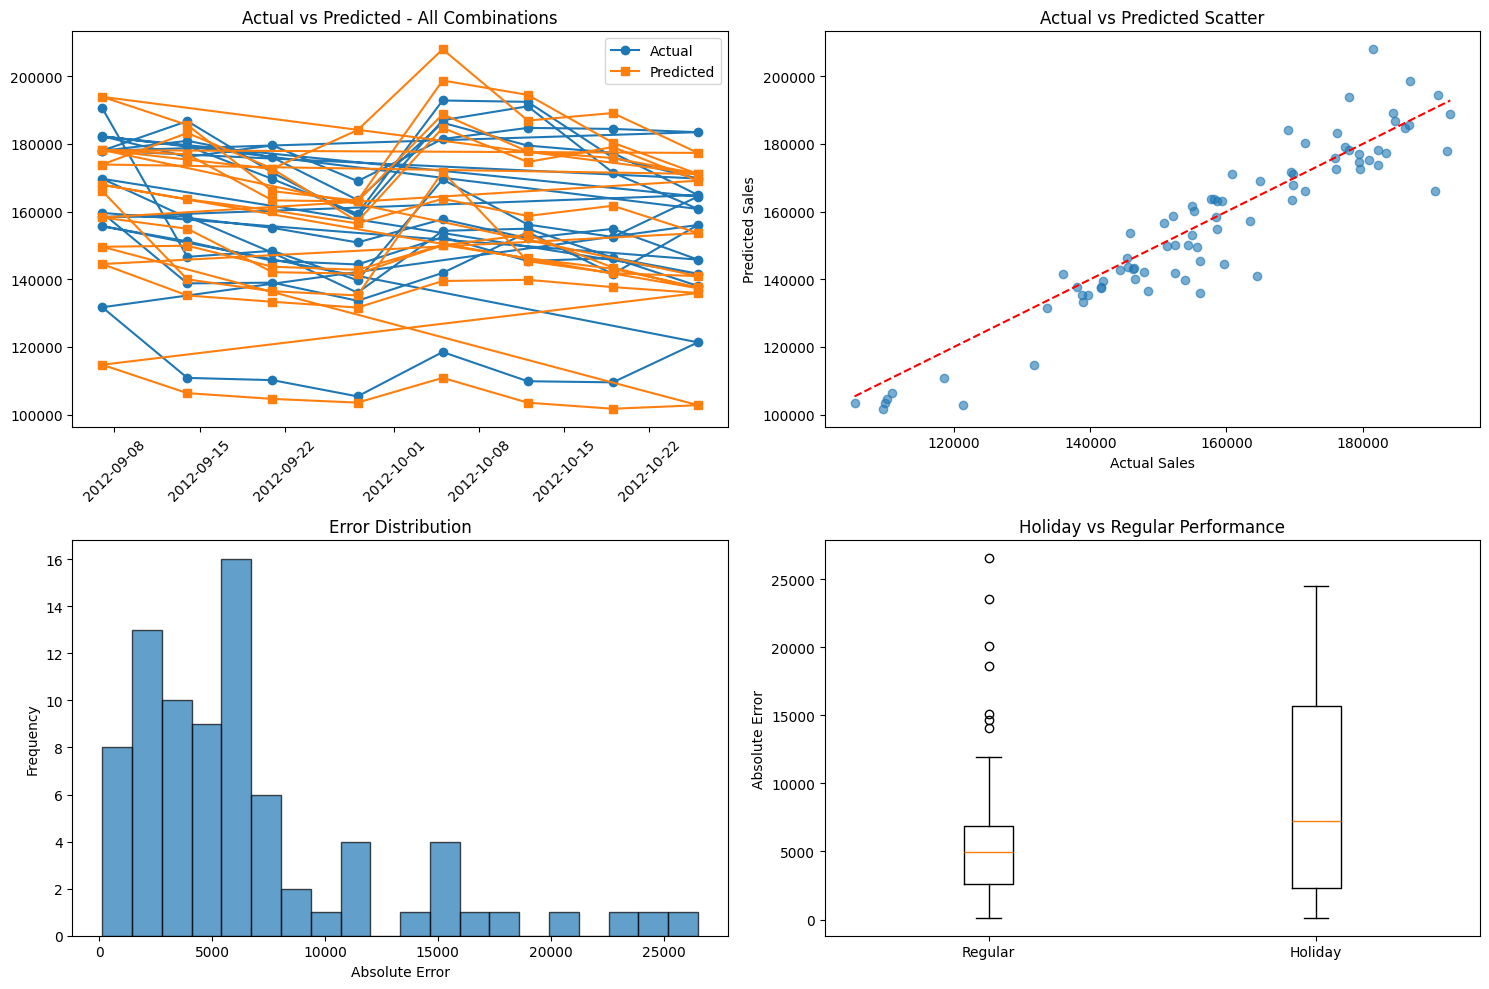

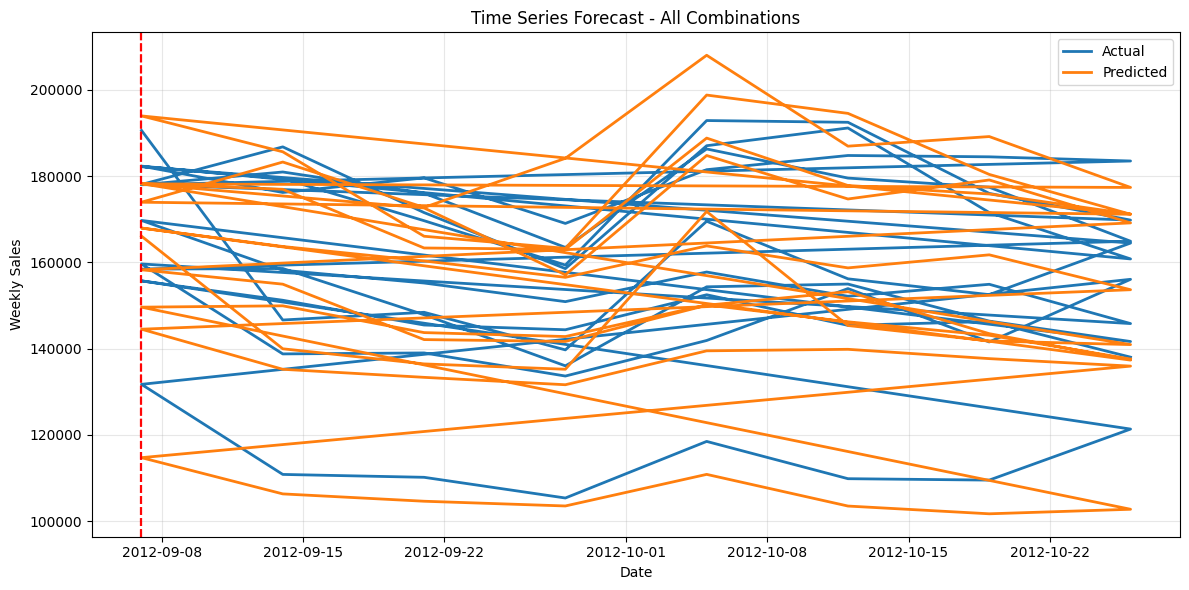

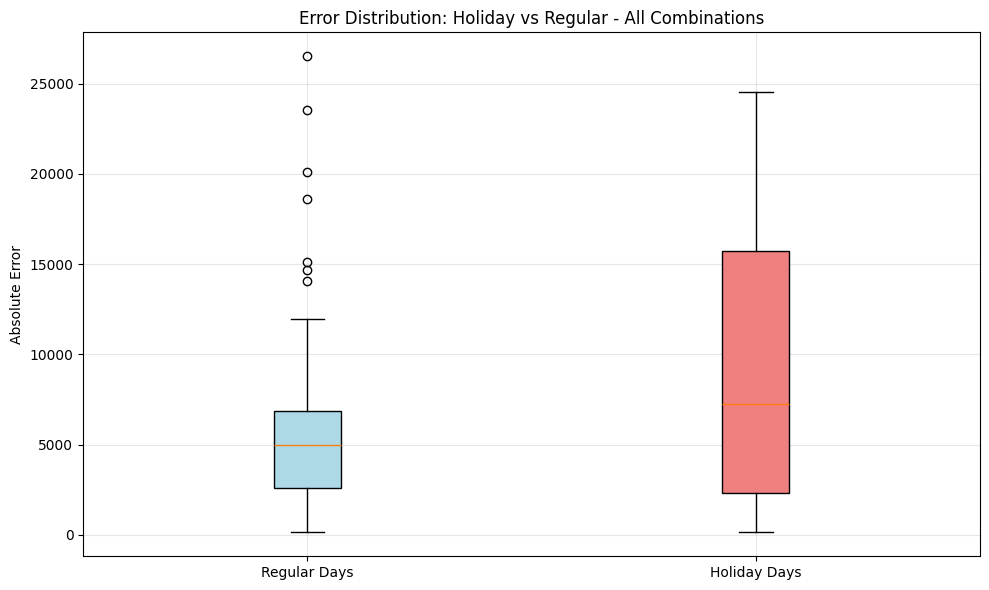


Detailed Metrics by Store-Department:
            mae          rmse          wmae  Store  Dept
0  11871.567079  14139.868210  16084.262079     14    92
1   4586.957698   6210.739914   4378.973478      2    92
2   7691.432127   8948.407888  10424.611596     20    92
3   9608.016162  12051.626083   9193.705289     13    92
4   3476.476602   4023.046346   2385.254575      4    92
5   3556.363948   3980.034640   2420.951741     20    95
6   5664.839439   5909.130021   4365.723413      4    95
7   8351.581739  10611.799247  10608.359146     27    92
8   8659.113779  10297.631188  11437.195994     14    95
9   2187.959050   2759.098481   3489.661399      2    95


overall/holiday_error_mean,▁
overall/holiday_error_std,▁
overall/mae,▁
overall/num_combinations,▁
overall/regular_error_mean,▁
overall/regular_error_std,▁
overall/rmse,▁
overall/wmae,▁
store_13_dept_92/data_points,▁
store_13_dept_92/mae,▁
store_13_dept_92/rmse,▁


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import wandb
warnings.filterwarnings('ignore')

class SimpleSARIMA:
    def __init__(self, wandb_project="sarima-forecasting"):
        self.train_df = None
        self.test_df = None
        self.features_df = None
        self.stores_df = None
        self.wandb_project = wandb_project

    def load_data(self, train_path, test_path, features_path, stores_path):
        self.train_df = pd.read_csv(train_path)
        self.test_df = pd.read_csv(test_path)
        self.features_df = pd.read_csv(features_path)
        self.stores_df = pd.read_csv(stores_path)

        self.train_df['Date'] = pd.to_datetime(self.train_df['Date'])
        self.test_df['Date'] = pd.to_datetime(self.test_df['Date'])
        self.features_df['Date'] = pd.to_datetime(self.features_df['Date'])

        print(f"Train shape: {self.train_df.shape}")
        print(f"Test shape: {self.test_df.shape}")

        return self.train_df, self.test_df

    def merge_basic_data(self):
        self.train_df = self.train_df.merge(
            self.features_df[['Store', 'Date', 'IsHoliday']],
            on=['Store', 'Date'],
            how='left',
            suffixes=('', '_features')
        )

        self.train_df['IsHoliday'] = self.train_df['IsHoliday_features'].fillna(self.train_df['IsHoliday'])
        self.train_df.drop('IsHoliday_features', axis=1, inplace=True)

        self.test_df = self.test_df.merge(
            self.features_df[['Store', 'Date', 'IsHoliday']],
            on=['Store', 'Date'],
            how='left',
            suffixes=('', '_features')
        )

        self.test_df['IsHoliday'] = self.test_df['IsHoliday_features'].fillna(self.test_df['IsHoliday'])
        self.test_df.drop('IsHoliday_features', axis=1, inplace=True)

        print(f"After merge - Train shape: {self.train_df.shape}")
        print(f"After merge - Test shape: {self.test_df.shape}")

        return self.train_df, self.test_df

    def train_sarima_single(self, store=1, dept=1, validation_weeks=8,
                           order=(1,1,1), seasonal_order=(1,1,1,52)):

        store_dept_data = self.train_df[
            (self.train_df['Store'] == store) &
            (self.train_df['Dept'] == dept)
        ].copy()

        store_dept_data = store_dept_data.sort_values('Date')

        if len(store_dept_data) < validation_weeks + 10:
            print(f"Not enough data for Store {store}, Dept {dept}")
            return None, None, None

        print(f"Training SARIMA for Store {store}, Dept {dept}")
        print(f"Data points: {len(store_dept_data)}")
        ts = store_dept_data['Weekly_Sales'].values
        dates = store_dept_data['Date'].values

        train_ts = ts[:-validation_weeks]
        val_ts = ts[-validation_weeks:]
        val_dates = dates[-validation_weeks:]

        try:
            model = SARIMAX(
                train_ts,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            results = model.fit(disp=False, maxiter=50)

            forecast = results.get_forecast(steps=validation_weeks)
            predictions = forecast.predicted_mean

            mae = mean_absolute_error(val_ts, predictions)
            mse = mean_squared_error(val_ts, predictions)
            rmse = np.sqrt(mse)

            val_data = store_dept_data.tail(validation_weeks)
            weights = val_data['IsHoliday'].apply(lambda x: 5 if x == 1 else 1).values
            wmae = np.sum(weights * np.abs(val_ts - predictions)) / np.sum(weights)

            print(f"Results for Store {store}, Dept {dept}:")
            print(f"  MAE: {mae:.2f}")
            print(f"  RMSE: {rmse:.2f}")
            print(f"  WMAE: {wmae:.2f}")

            wandb.log({
                f"store_{store}_dept_{dept}/mae": mae,
                f"store_{store}_dept_{dept}/rmse": rmse,
                f"store_{store}_dept_{dept}/wmae": wmae,
                f"store_{store}_dept_{dept}/data_points": len(store_dept_data)
            })

            results_df = pd.DataFrame({
                'Date': val_dates,
                'Actual': val_ts,
                'Predicted': predictions,
                'Error': np.abs(val_ts - predictions),
                'IsHoliday': val_data['IsHoliday'].values,
                'Store': store,
                'Dept': dept
            })

            return results, results_df, {'mae': mae, 'rmse': rmse, 'wmae': wmae}

        except Exception as e:
            print(f"Error training SARIMA for Store {store}, Dept {dept}: {str(e)}")
            return None, None, None

    def validate_multiple_stores(self, store_dept_pairs=None, validation_weeks=8,
                                order=(1,1,1), seasonal_order=(1,1,1,52)):

        if store_dept_pairs is None:
            top_combinations = (self.train_df.groupby(['Store', 'Dept'])['Weekly_Sales']
                              .sum().nlargest(10).index.tolist())
        else:
            top_combinations = store_dept_pairs

        print(f"Validating on {len(top_combinations)} store-department combinations")

        all_results = []
        all_metrics = []

        for store, dept in top_combinations:
            model, results_df, metrics = self.train_sarima_single(
                store=store,
                dept=dept,
                validation_weeks=validation_weeks,
                order=order,
                seasonal_order=seasonal_order
            )

            if results_df is not None:
                results_df['Store'] = store
                results_df['Dept'] = dept
                all_results.append(results_df)

                metrics['Store'] = store
                metrics['Dept'] = dept
                all_metrics.append(metrics)

        if all_results:
            combined_results = pd.concat(all_results, ignore_index=True)
            combined_metrics = pd.DataFrame(all_metrics)

            overall_mae = combined_results['Error'].mean()
            overall_rmse = np.sqrt(combined_results['Error'].var())

            weights = combined_results['IsHoliday'].apply(lambda x: 5 if x == 1 else 1)
            overall_wmae = np.sum(weights * combined_results['Error']) / np.sum(weights)

            print(f"\nOverall Validation Results:")
            print(f"Overall MAE: {overall_mae:.2f}")
            print(f"Overall RMSE: {overall_rmse:.2f}")
            print(f"Overall WMAE: {overall_wmae:.2f}")

            wandb.log({
                "overall/mae": overall_mae,
                "overall/rmse": overall_rmse,
                "overall/wmae": overall_wmae,
                "overall/num_combinations": len(top_combinations)
            })

            return combined_results, combined_metrics, {
                'overall_mae': overall_mae,
                'overall_rmse': overall_rmse,
                'overall_wmae': overall_wmae
            }
        else:
            print("No successful validations!")
            return None, None, None

    def plot_results(self, results_df, store=None, dept=None):

        if store is not None and dept is not None:
            plot_data = results_df[
                (results_df['Store'] == store) &
                (results_df['Dept'] == dept)
            ]
            title = f"Store {store}, Dept {dept}"
            plot_prefix = f"store_{store}_dept_{dept}"
        else:
            plot_data = results_df
            title = "All Combinations"
            plot_prefix = "overall"

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0, 0].plot(plot_data['Date'], plot_data['Actual'],
                       label='Actual', marker='o')
        axes[0, 0].plot(plot_data['Date'], plot_data['Predicted'],
                       label='Predicted', marker='s')
        axes[0, 0].set_title(f'Actual vs Predicted - {title}')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)

        axes[0, 1].scatter(plot_data['Actual'], plot_data['Predicted'], alpha=0.6)
        axes[0, 1].plot([plot_data['Actual'].min(), plot_data['Actual'].max()],
                       [plot_data['Actual'].min(), plot_data['Actual'].max()], 'r--')
        axes[0, 1].set_xlabel('Actual Sales')
        axes[0, 1].set_ylabel('Predicted Sales')
        axes[0, 1].set_title('Actual vs Predicted Scatter')

        axes[1, 0].hist(plot_data['Error'], bins=20, alpha=0.7, edgecolor='black')
        axes[1, 0].set_xlabel('Absolute Error')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Error Distribution')

        holiday_errors = plot_data[plot_data['IsHoliday'] == 1]['Error']
        regular_errors = plot_data[plot_data['IsHoliday'] == 0]['Error']

        axes[1, 1].boxplot([regular_errors, holiday_errors],
                          labels=['Regular', 'Holiday'])
        axes[1, 1].set_ylabel('Absolute Error')
        axes[1, 1].set_title('Holiday vs Regular Performance')

        plt.tight_layout()

        wandb.log({f"{plot_prefix}/forecast_plot": wandb.Image(fig)})

        plt.show()

        fig2, ax = plt.subplots(1, 1, figsize=(12, 6))
        dates = pd.to_datetime(plot_data['Date'])
        ax.plot(dates, plot_data['Actual'], label='Actual', linewidth=2)
        ax.plot(dates, plot_data['Predicted'], label='Predicted', linewidth=2)

        holiday_dates = dates[plot_data['IsHoliday'] == 1]
        for hdate in holiday_dates:
            ax.axvline(x=hdate, color='red', alpha=0.3, linestyle='--')

        ax.set_title(f'Time Series Forecast - {title}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Weekly Sales')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        wandb.log({f"{plot_prefix}/time_series": wandb.Image(fig2)})
        plt.show()

        if len(holiday_errors) > 0 and len(regular_errors) > 0:
            fig3, ax = plt.subplots(1, 1, figsize=(10, 6))

            data_for_plot = [regular_errors, holiday_errors]
            labels = ['Regular Days', 'Holiday Days']

            bp = ax.boxplot(data_for_plot, labels=labels, patch_artist=True)
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][1].set_facecolor('lightcoral')

            ax.set_ylabel('Absolute Error')
            ax.set_title(f'Error Distribution: Holiday vs Regular - {title}')
            ax.grid(True, alpha=0.3)

            plt.tight_layout()
            wandb.log({f"{plot_prefix}/holiday_comparison": wandb.Image(fig3)})
            plt.show()

            wandb.log({
                f"{plot_prefix}/holiday_error_mean": holiday_errors.mean(),
                f"{plot_prefix}/regular_error_mean": regular_errors.mean(),
                f"{plot_prefix}/holiday_error_std": holiday_errors.std(),
                f"{plot_prefix}/regular_error_std": regular_errors.std(),
            })

def main():
    wandb.init(project="walmart-sales-prediction", name="sarima-simple")

    sarima = SimpleSARIMA()
    train_path = '/content/drive/MyDrive/ML/final/train.csv'
    test_path = '/content/drive/MyDrive/ML/final/test.csv'
    features_path = '/content/drive/MyDrive/ML/final/features.csv'
    stores_path = '/content/drive/MyDrive/ML/final/stores.csv'

    wandb.config.update({
        "validation_weeks": 8,
        "sarima_order": (1, 1, 1),
        "seasonal_order": (1, 1, 1, 52),
        "train_path": train_path,
        "test_path": test_path,
        "features_path": features_path,
        "stores_path": stores_path
    })

    print("Loading data...")
    sarima.load_data(train_path, test_path, features_path, stores_path)

    print("Merging basic data...")
    sarima.merge_basic_data()
    print("Single Store-Department Validation")

    model, results_df, metrics = sarima.train_sarima_single(
        store=1,
        dept=1,
        validation_weeks=8,
        order=(1,1,1),
        seasonal_order=(1,1,1,52)
    )

    if results_df is not None:
        print("\nPlotting results for Store 1, Dept 1...")
        sarima.plot_results(results_df, store=1, dept=1)

    print("Multiple Store-Department Validation")

    combined_results, combined_metrics, overall_metrics = sarima.validate_multiple_stores(
        store_dept_pairs=None,
        validation_weeks=8,
        order=(1,1,1),
        seasonal_order=(1,1,1,52)
    )

    if combined_results is not None:
        print("\nPlotting combined results...")
        sarima.plot_results(combined_results)
        print("\nDetailed Metrics by Store-Department:")
        print(combined_metrics)

        metrics_table = wandb.Table(dataframe=combined_metrics)
        wandb.log({"metrics_by_store_dept": metrics_table})

    wandb.finish()
    return sarima, combined_results, combined_metrics

if __name__ == "__main__":
    sarima, results, metrics = main()